# 1. Imports

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import seaborn as sns

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic        # Modello olistico
mp_drawing = mp.solutions.drawing_utils     # Utilità di disegno

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti i colori BGR -> RGB
    image.flags.writeable = False                   # Imposta l'immagine come non scrivibile
    results = model.process(image)                  # Fai la predizione
    image.flags.writeable = True                    # Reimposta l'immagine come scrivibile
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Converti i colori RGB -> BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)      # Disegna le connessioni del volto
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)          # Disegna le connessioni del corpo
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)     # Disegna le connessioni della mano sinistra
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    # Disegna le connessioni della mano destra

In [5]:
def draw_styled_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              #landmark_drawing_spec=mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              #connection_drawing_spec=mp_drawing.DrawingSpec(color=(80,255,121), thickness=1, circle_radius=1)   
                              #)                                                                                                 # Disegna le connessioni del volto
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              landmark_drawing_spec=mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              connection_drawing_spec=mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                              )                                                                                                 # Disegna le connessioni del corpo
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec=mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              connection_drawing_spec=mp_drawing.DrawingSpec(color=(80,255,10), thickness=2, circle_radius=2)
                              )                                                                                                 # Disegna le connessioni della mano sinistra
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec=mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              connection_drawing_spec=mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )                                                                                                 # Disegna le connessioni della mano destra

In [6]:
cap = cv2.VideoCapture(0)  # Inizializza il VideoCapture sulla webcam

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:   # Setta il modello olistico di mediapipe
    while cap.isOpened():                                           # Finché cap è aperto:
        ret, frame = cap.read()                                     # Leggi il fotogramma corrente
        image, results = mediapipe_detection(frame, holistic)       # Fai la predizione sul fotogramma corrente, con il modello olistico
        draw_styled_landmarks(image, results)                       # Disegna i landmarks sull'immagine
        cv2.imshow('WebCam', image)                                # Mostra il fotogramma in una finestra
        if cv2.waitKey(1) == ord('q'):                              # Se viene premuto il tasto 'q'
            break                                                   # Esci dal ciclo while
    
    cap.release()               # Rilascia il VideoCapture
    cv2.destroyAllWindows()     # Distruggi tutte le finestre aperte da OpenCV

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


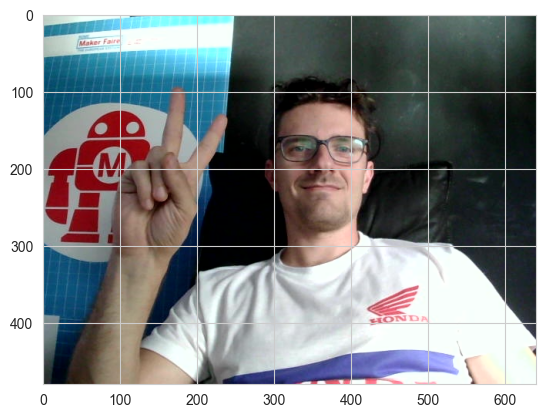

In [205]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


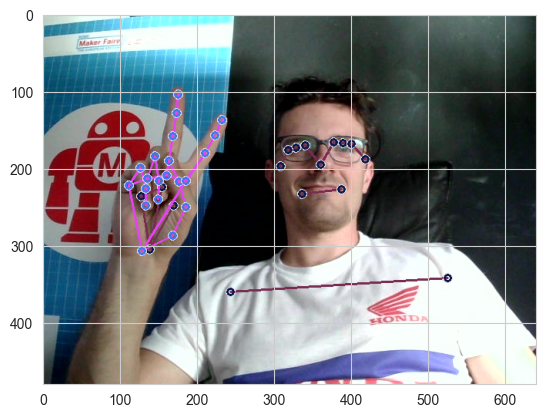

In [206]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [7]:
# Crea un array che contiene i valori di tutte le dimensioni di tutti i landmarks trovati
# Se un elemento (es: la mano sinistra) non viene trovato, allora crea un array di zeri con la stessa dimensione che avrebbe l'array generato da mediapipe
# In questo modo l'array finale, che passeremo al modello, avrà sempre la stessa dimensione
def extract_keypoints(results):     
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

# 4. Setup Folders for Collection

In [8]:
# Cartella per i dati esportati (array numpy)
DATA_PATH = os.path.join('MP_Data')

# Azioni che proviamo a rilevare
actions = np.array(['_', 'ciao', 'grazie', 'tiamo'])

# Numero di video per ogni azione
no_sequences = 30

# Numero di frame per ogni video
sequences_length = 30

In [9]:
# Creo le cartelle che conterranno i frame dei singoli video per ogni azione
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [15]:
cap = cv2.VideoCapture(0)  # Inizializza il VideoCapture sulla webcam

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:   # Setta il modello olistico di mediapipe                                           
        
        for action in actions:
            for sequence in range(no_sequences):
                for frame_num in range(sequences_length):
                    
                    ret, frame = cap.read()                                     # Leggi il fotogramma corrente
                    image, results = mediapipe_detection(frame, holistic)       # Fai la predizione sul fotogramma corrente, con il modello olistico
                    draw_styled_landmarks(image, results)                       # Disegna i landmarks sull'immagine
                    
                    cv2.putText(img=image, text='Registrazione azione: "{}". Video num. # {}'.format(action, sequence), org=(15,12),
                                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
                    cv2.imshow('WebCam', image)
                    
                    if frame_num == 0:
                        cv2.putText(img=image, text='INIZIO REGISTRAZIONE', org=(120,200),
                                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 255), thickness=2, lineType=cv2.LINE_AA)
                        cv2.imshow('WebCam', image)
                        cv2.waitKey(2000)
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)
                        
                    if cv2.waitKey(1) == ord('q'):                              
                        break                                                   
    
        cap.release()               # Rilascia il VideoCapture
        cv2.destroyAllWindows()     # Distruggi tutte le finestre aperte da OpenCV

In [221]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
label_map

{'_': 0, 'ciao': 1, 'grazie': 2, 'tiamo': 3}

In [13]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequences_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
np.array(sequences).shape

(120, 30, 258)

In [15]:
np.array(labels).shape

(120,)

In [16]:
X = np.array(sequences)

In [17]:
X.shape

(120, 30, 258)

In [18]:
y = to_categorical(labels).astype(int)

In [ ]:
y

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((114, 30, 258), (6, 30, 258), (114, 4), (6, 4))

# 7. Build and Train LSTM Neural Network

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [23]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [24]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            82688     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 237,284
Trainable params: 237,284
Non-trainable params: 0
__________________________________________________

# 8. Make Predictions

In [28]:
res = model.predict(X_test)

In [29]:
actions[np.argmax(res[1])]

'tiamo'

In [30]:
actions[np.argmax(y_test[1])]

'tiamo'

# 9. Save Weights

In [41]:
model.save('no_face_model.h5')

In [60]:
del model

In [27]:
model.load_weights('no_face_model.h5')

# 10. Evaluation Using Confusion Matrix and Accuracy

In [31]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, accuracy_score

In [32]:
yhat = model.predict(X_test)

In [33]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [34]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[5, 0],
        [0, 1]],

       [[4, 0],
        [0, 2]],

       [[5, 0],
        [0, 1]],

       [[4, 0],
        [0, 2]]], dtype=int64)

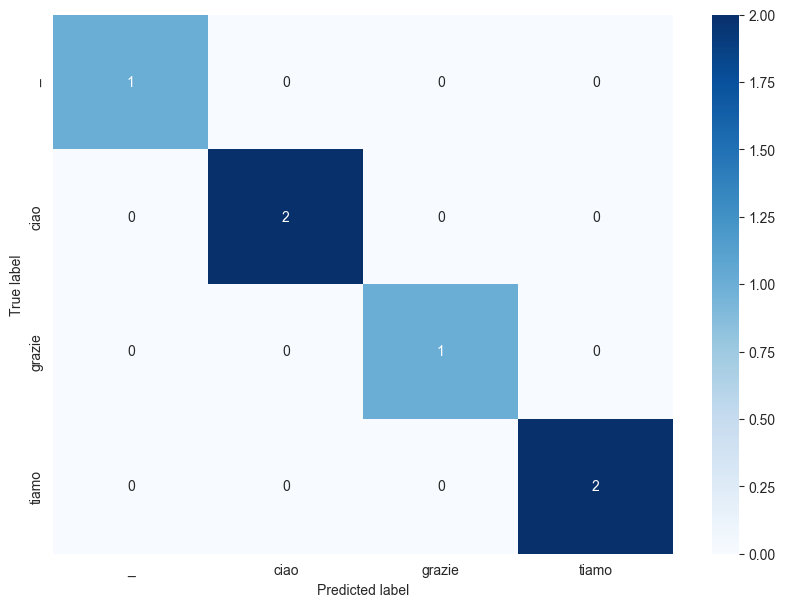

In [35]:
# Supponiamo che y_true e y_pred siano i tuoi array
y_true = ytrue  # Esempio: [1, 0, 1, 2, ...]
y_pred = yhat  # Esempio: [1, 0, 2, 2, ...]

# Calcola la matrice di confusione
cm = confusion_matrix(y_true, y_pred)

# Visualizza la matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map, yticklabels=label_map)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [37]:
res

array([[4.9988779e-25, 1.2908747e-14, 9.9858601e-23, 1.0000000e+00],
       [3.2768296e-26, 1.6824560e-14, 7.9441903e-23, 1.0000000e+00],
       [1.8451634e-15, 1.0000000e+00, 1.6948743e-08, 5.9530194e-09],
       [1.0000000e+00, 5.0352030e-25, 5.4803088e-28, 1.7017768e-16],
       [6.8918410e-10, 9.9994063e-01, 1.1483298e-05, 4.7895606e-05],
       [2.7053296e-08, 2.3833619e-04, 9.9976164e-01, 8.5139756e-10]],
      dtype=float32)

In [38]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    
    for num, prob in enumerate(res[1:]):
        cv2.rectangle(img=output_frame, pt1=(0,60+num*40), pt2=(int(prob*100), 90+num*40), color=colors[num], thickness=-1)
        cv2.putText(output_frame, actions[1:][num]+f' {round(prob, 2)}', (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# Variabili per la predizione
sequence = []
sentence = []
predictions = []
threshold = 0.9
res = []
cap = cv2.VideoCapture(0)  # Inizializza il VideoCapture sulla webcam

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:   # Setta il modello olistico di mediapipe
    while cap.isOpened():                                           # Finché cap è aperto:
        ret, frame = cap.read()                                     # Leggi il fotogramma corrente
        image, results = mediapipe_detection(frame, holistic)       # Fai la predizione sul fotogramma corrente, con il modello olistico
        #draw_styled_landmarks(image, results)                       # Disegna i landmarks sull'immagine
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            if actions[np.argmax(res)] != '_':
                print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-15:])[0] == np.argmax(res):
                if actions[np.argmax(res)] != '_':
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                
        if len(sentence) > 5:
            sentence = sentence[-5:]
            
        image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
        
        cv2.imshow('WebCam', image)                                # Mostra il fotogramma in una finestra
        if cv2.waitKey(1) == ord('q'):                              # Se viene premuto il tasto 'q'
            break                                                   # Esci dal ciclo while
    
    cap.release()               # Rilascia il VideoCapture
    cv2.destroyAllWindows()     # Distruggi tutte le finestre aperte da OpenCV

In [66]:
cap.release()
cv2.destroyAllWindows()